In [1]:
import numpy as np
import copy
import time as Time
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.indicators.hv import HV
from matplotlib.pyplot import MultipleLocator

In [2]:
def init_pop(constr, pop_num):
    constr_ = copy.copy(constr_mat)
    considered = []
    threshold = constr_.shape[0]
    while True:
        if len(considered)<threshold:
            no_immediate_work = np.argwhere(np.all(constr_[...,:]==0,axis=0)).reshape(-1)
            for ele in considered:
                no_immediate_work = np.delete(no_immediate_work, no_immediate_work == ele)
            no_immediate_work = int(np.random.choice(no_immediate_work))
            considered.append(no_immediate_work)
            constr_[no_immediate_work, :] = 0
        else:
            break
            
    pops = np.array([considered])
    while True:
        if pops.shape[0]<pop_num:
            constr_ = copy.copy(constr_mat)
            considered = []
            threshold = constr_.shape[0]
            while True:
                if len(considered)<threshold:
                    no_immediate_work = np.argwhere(np.all(constr_[...,:]==0,axis=0)).reshape(-1)
                    for ele in considered:
                        no_immediate_work = np.delete(no_immediate_work, no_immediate_work == ele)
                    no_immediate_work = int(np.random.choice(no_immediate_work))
                    considered.append(no_immediate_work)
                    constr_[no_immediate_work, :] = 0
                else:
                    break
            pops = np.append(pops, np.array([considered]), axis=0)
        else:
            return pops

In [3]:
class Node:
    def __init__(self, workNum, parent, childs, branchNum, visitNum, score):
        self.workNum = workNum
        self.parent = parent
        self.childs = childs
        self.branchNum = branchNum
        self.visitNum = visitNum
        self.score = score

In [4]:
class Tree(object):
    def __init__(self, depth):
        self.level = [[] for _ in range(depth+1)]
        
    def add(self, levelNum, item):
        existSet = [[ele.parent, ele.workNum] for ele in self.level[levelNum]] # 
        if [item.parent, item.workNum] not in existSet:
            self.level[levelNum].append(item)
            return [levelNum, len(self.level[levelNum])-1]
        else:
            return None

In [5]:
def getChild(constr, consideredWork, choicedNowWork):
    constr_ = copy.deepcopy(constr)
    
    if choicedNowWork==-1:
        canDoWork = np.argwhere(np.all(constr_[...,:]==0,axis=0)).reshape(-1)
    else:
        worked = [ele.workNum for ele in consideredWork]
        constr_[worked, :] = 0
        canDoWork = np.argwhere(np.all(constr_[...,:]==0,axis=0)).reshape(-1)
        for ele in worked:
            canDoWork = np.delete(canDoWork, canDoWork == ele)
    return canDoWork

In [6]:
def getChildInfo(t, childPositionInTree):
    childs = [t.level[pos[0]][pos[1]] for pos in childPositionInTree]
    branchOfChilds = np.array([child.branchNum for child in childs])
    visitNumOfChilds = np.array([child.visitNum for child in childs])
    scoreOfChilds = np.array([child.score for child in childs])
    return branchOfChilds, visitNumOfChilds, scoreOfChilds

In [7]:
def softmax(f):
    f -= np.max(f)
    return np.exp(f) / np.sum(np.exp(f))
# ***************
# 
# ***************
# def getChoiceProb(branchInfo, visitNumInfo, scoreInfo, visitNumOfParent, temp):
#     '''
#     branchInfo: 1*childNum
#     visitNumInfo: 1*childNum
#     scoreInfo: 1*childNum
#     visitNumOfParent: 1*1
#     temp: 温度
#     '''
#     logits1 = -1*np.log((visitNumInfo+0.000001)/(visitNumOfParent + 0.000001))+0.00000001
#     logits2 = np.exp(-1*visitNumInfo/branchInfo)+0.00000001
#     logits = logits1*logits2
#     prob = softmax(logits/temp)
#     return prob

def getChoiceProb(branchInfo, visitNumInfo, visitNumOfParent, temp, p):
    '''
    branchInfo: 1*childNum
    visitNumInfo: 1*childNum
    scoreInfo: 1*childNum
    visitNumOfParent: 1*1
    temp: 温度
    '''
    
    alpha_Hb = (visitNumInfo+0.000000000001)/(visitNumOfParent + 0.000000001)
    alpha_Hb = np.min(np.concatenate((alpha_Hb[np.newaxis,...], 
                                      np.ones(alpha_Hb.shape)[np.newaxis,...])), axis=0)
    beta_Hb = (visitNumInfo+0.000000000001)/(branchInfo + 0.000000001)
    beta_Hb = np.min(np.concatenate((beta_Hb[np.newaxis,...],
                                      np.ones(beta_Hb.shape)[np.newaxis,...])), axis=0)
    if np.random.uniform() >= p:
        logits = -1*np.log(beta_Hb)
    else:
        logits = -1*np.log(alpha_Hb)
    prob = softmax(logits/temp)
    return prob

In [8]:
def position2work(t, workPosition):
    '''
    t：树
    workPosition：序列元素在树种的位置 [[第几层，第几个],[第几层，第几个],......,[第几层，第几个]]
    '''
    return [t.level[ele[0]][ele[1]].workNum for ele in workPosition]

In [9]:
def backPropagationBranchNum(tr,solution):
    # 功能1：统计各个节点后面的分支数目
    so = copy.deepcopy(solution)
    so.reverse()
    for ele in so:
        # tree.level[ele[0]][ele[1]] 当前节点
        if tr.level[ele[0]][ele[1]].childs!=None:
            tr.level[ele[0]][ele[1]].branchNum = sum([tr.level[ele1[0]][ele1[1]].branchNum 
                                                        for ele1 in tr.level[ele[0]][ele[1]].childs])   

In [10]:
def backPropagationScore(solution, fitness):
    so = copy.deepcopy(solution)
    for ele in so:
        tree.level[ele[0]][ele[1]].score = tree.level[ele[0]][ele[1]].score + fitness # 跟新适应度值

In [11]:
class Node:
    def __init__(self, workNum, parent, childs, branchNum, visitNum, score):
        '''
        parent[第几层，第几个]
        childs[[第几层，第几个],[第几层，第几个],......,[第几层，第几个]]
        attribute: workNum; parent; childs; branchNum; visitNum; score
        '''
        self.workNum = workNum
        self.parent = parent
        self.childs = childs
        self.branchNum = branchNum
        self.visitNum = visitNum
        self.score = score

def initial(constr_mat, popNum, partNum, tempary):
    tree = Tree(partNum)

    solutionS = []
    while len(solutionS)<popNum:
        workSequence = []
        workPositionInTree = []
        while len(workSequence)<partNum:
            layer = len(workSequence)
            if layer==0:
                rootNode = Node(-1,parent=None,childs=None,branchNum=1,visitNum=1,score=0)
                zz = tree.add(layer,rootNode)
            else:
                tree.level[0][0].visitNum = sum([tree.level[rootChildIndex[0]][rootChildIndex[1]].visitNum 
                                                 for rootChildIndex in tree.level[0][0].childs])

            if len(workSequence)==0:
                layer = 0
                layer_nodePosition = 0
            else:
                layer = workPositionInTree[-1][0]
                layer_nodePosition = workPositionInTree[-1][1]

            nowNode = tree.level[layer][layer_nodePosition]
            childWorkS = getChild(constr_mat, workSequence, tree.level[layer][layer_nodePosition].workNum)

            nodeChilds = [Node(cw, 
                               parent=[layer, layer_nodePosition], 
                               childs=None,branchNum=1,visitNum=0,score=0) for cw in childWorkS]

            childPositionS = []
            for nodeChild in nodeChilds:
                childPosition = tree.add(layer+1, nodeChild)
                if childPosition!=None:
                    childPositionS.append(childPosition)

            if tree.level[layer][layer_nodePosition].childs==None and len(childPositionS)!=0:
                tree.level[layer][layer_nodePosition].childs = childPositionS
            elif len(childPositionS)!=0:
                tree.level[layer][layer_nodePosition].childs = tree.level[layer][layer_nodePosition].childs+childPositionS

            cS = tree.level[layer][layer_nodePosition].childs

            branchs, visitNums, scores = getChildInfo(tree, cS)
            
            probablity = getChoiceProb(branchs, 
                                   visitNums, 
                                       tree.level[layer][layer_nodePosition].visitNum, 
                                       tempary, 1-len(solutionS)/popNum)
            selectedNode = np.random.choice(range(len(cS)), p=probablity)

            tree.level[cS[selectedNode][0]][cS[selectedNode][1]].visitNum += 1

            workSequence.append(tree.level[cS[selectedNode][0]][cS[selectedNode][1]])
            workPositionInTree.append([cS[selectedNode][0], cS[selectedNode][1]])
        solutionS.append(workPositionInTree)

        for ele in solutionS:
            backPropagationBranchNum(tree, ele)
        tree.level[0][0].branchNum = sum([tree.level[c[0]][c[1]].branchNum for c in tree.level[0][0].childs])
    pop_s = np.array([position2work(tree, ele) for ele in solutionS])
    return pop_s

# 初始化对比

In [12]:
constr_mat = np.array([[0,1,1,0,1,0,0,0],
                       [0,0,0,0,0,0,0,1],
                       [0,0,0,0,0,1,0,0],
                       [0,0,0,0,0,0,0,0],
                       [0,0,0,0,0,0,0,1],
                       [0,0,0,0,0,0,0,1],
                       [0,0,0,1,0,0,0,0],
                       [0,0,0,0,0,0,1,0]])
partNum = 8    

In [13]:
a = []
for _ in range(100):
    pop_s = initial(constr_mat, 12, partNum, 0.01)
    a.append(np.unique(pop_s,axis=0).shape[0])

In [14]:
b = []
for _ in range(100):
    pop_s = init_pop(constr_mat, 12)
    b.append(np.unique(pop_s,axis=0).shape[0])

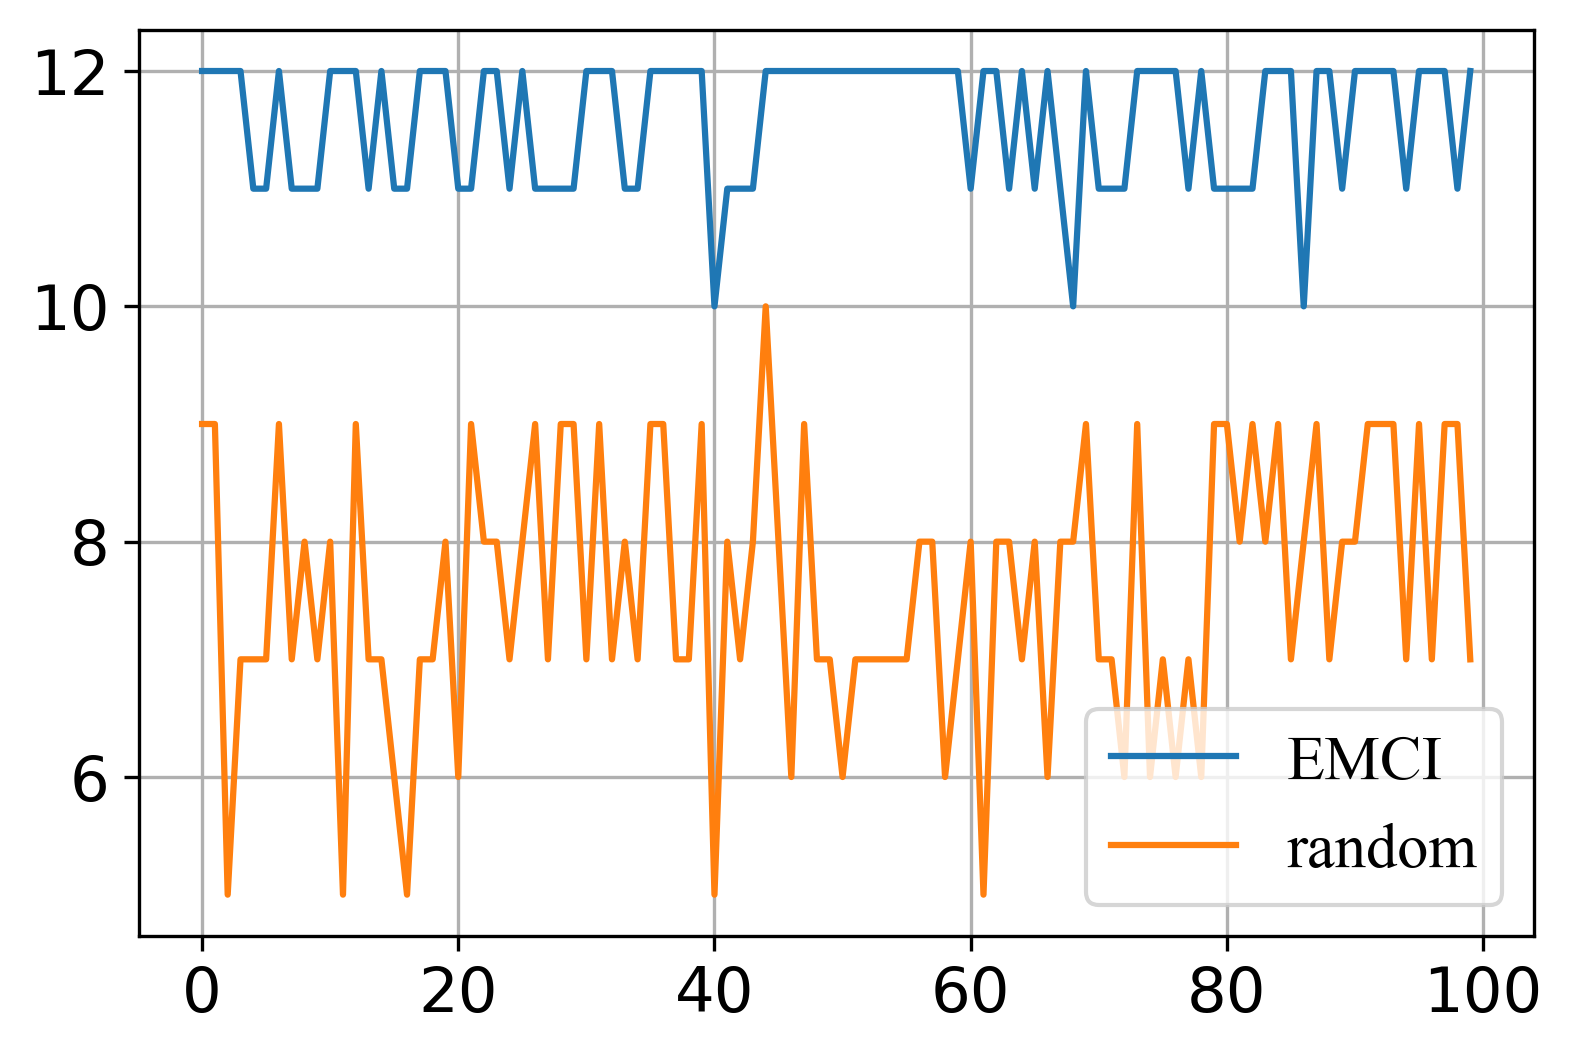

In [15]:
plt.figure(dpi=300)
plt.plot(a)
plt.plot(b)
plt.grid()
font1 = {'family':'Times New Roman',
        'size':15}
plt.tick_params(labelsize=15, direction='out')
plt.legend(['EMCI','random'],prop=font1)